# **Datasets that were used for this project**

All datasets have been taken from Kaggle.com and are free to use by anyone.

> The first dataset is Fruits 360: https://www.kaggle.com/moltean/fruits

> The second dataset that is used is Waste dataset: https://www.kaggle.com/szdxfkmgnb/waste-classification

> The third dataset that is used is called Garbage Classification (12 classes) dataset: https://www.kaggle.com/mostafaabla/garbage-classification?fbclid=IwAR06p8i1Ct4-XUPC8WiYsPozvibMeHAmuHZ5iW3Zi3BVtWvLNmEk-rzBjnA







# **Google Colab and Kaggle Union**
It is not necessary to unite Google Colab and Kaggle, but I am uniting it for the fact that downloading the datasets and uploading them in the Google Colab is going to be much faster than in Google Drive.

> https://www.kaggle.com/general/74235





In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evaldasvainaviius","key":"8d0d9c77b4504ac688383a7b9f21d27f"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d evaldasvainaviius/final-year-project
! unzip final-year-project

In [ ]:
! kaggle datasets download -d moltean/fruits
! unzip fruits.zip

In [ ]:
#Importing the necessary libraries for the code

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Printing all file names that exist in fruits-360 folder
# In addition, getting all the subfolders from Training folder (which will be all the classes of fruits)

data_dir = '/content/Dataset(Wastes)'
#data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
print("******************************************************************************")
classes = os.listdir(data_dir + "/Training")
print('There are: ' + str(len(classes)) + ' classes. ', classes)

Folders : ['Training', 'Test']
******************************************************************************
There are: 9 classes.  ['biological', 'battery', 'metal', 'glass', 'clothes', 'cardboard', 'paper', 'plastic', 'shoes']


In [ ]:
#Getting the total amount of images in Training folder and in Test folder

transforming = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

dataset = ImageFolder(data_dir + '/Training', transform=transforming)
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=transforming)
print('Size of test dataset :', len(test))

Size of training dataset : 13039
Size of test dataset : 7491


In [ ]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
1


Label:  biological (1)


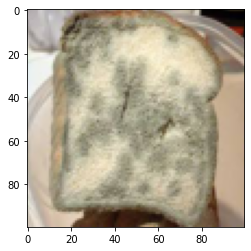

In [ ]:
# function for showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

# **Preparing data for training**

In [ ]:
torch.manual_seed(20)
val_size = len(dataset)//3
train_size = len(dataset) - val_size
print(val_size)

4346


In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(8693, 4346)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds,batch_size,shuffle= True, 
                          num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds,batch_size*2,num_workers=4, pin_memory=True)

test_loader = DataLoader(test,batch_size*2,num_workers=4, pin_memory=True)

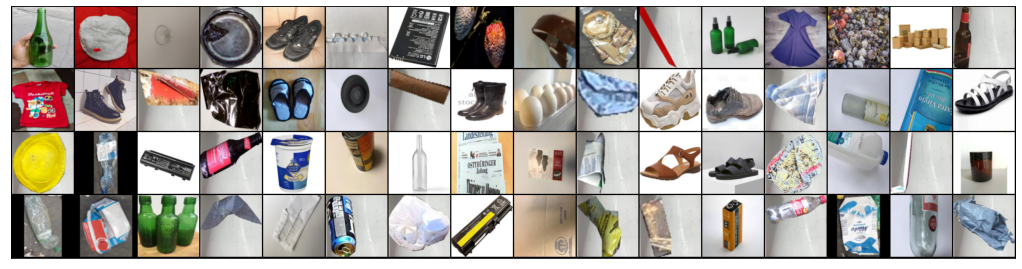

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# **FeedForward Neural Network (FNN)**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*100*100
output_size = 131

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [ ]:
model = to_device(Model(input_size, output_size), device)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.0, 'val_loss': 4.874202251434326}]

In [ ]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 2.6645, val_loss: 2.0556, val_acc: 0.2592



Epoch [1], train_loss: 2.0035, val_loss: 1.9903, val_acc: 0.2897



Epoch [2], train_loss: 1.9039, val_loss: 1.8334, val_acc: 0.3345



Epoch [3], train_loss: 1.8191, val_loss: 1.7510, val_acc: 0.3624



Epoch [4], train_loss: 1.7213, val_loss: 1.6682, val_acc: 0.4264



Epoch [5], train_loss: 1.6523, val_loss: 1.5950, val_acc: 0.4370



Epoch [6], train_loss: 1.5977, val_loss: 1.4996, val_acc: 0.4621


In [ ]:
history += fit(8, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 1.4657, val_loss: 1.4829, val_acc: 0.4660



Epoch [1], train_loss: 1.4546, val_loss: 1.4712, val_acc: 0.4699



Epoch [2], train_loss: 1.4468, val_loss: 1.4607, val_acc: 0.4729



Epoch [3], train_loss: 1.4393, val_loss: 1.4583, val_acc: 0.4699



Epoch [4], train_loss: 1.4340, val_loss: 1.4515, val_acc: 0.4738



Epoch [5], train_loss: 1.4281, val_loss: 1.4427, val_acc: 0.4789



Epoch [6], train_loss: 1.4222, val_loss: 1.4397, val_acc: 0.4766



Epoch [7], train_loss: 1.4179, val_loss: 1.4397, val_acc: 0.4715


In [ ]:
history += fit(3, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 1.4132, val_loss: 1.4279, val_acc: 0.4835



Epoch [1], train_loss: 1.4076, val_loss: 1.4301, val_acc: 0.4791



Epoch [2], train_loss: 1.4025, val_loss: 1.4211, val_acc: 0.4924


In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.4547159671783447, 'val_loss': 1.630484938621521}

# **Convolutional Neural Network (CNN)**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    #print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 100, 100])
out.shape: torch.Size([64, 131])


In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_acc': 0.0, 'val_loss': 4.854931831359863}]

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.4829, val_loss: 1.3365, val_acc: 0.5173



Epoch [1], train_loss: 1.2561, val_loss: 1.1897, val_acc: 0.5709



Epoch [2], train_loss: 1.1118, val_loss: 1.1052, val_acc: 0.6087



Epoch [3], train_loss: 0.9591, val_loss: 1.0259, val_acc: 0.6162



Epoch [4], train_loss: 0.8379, val_loss: 0.9259, val_acc: 0.6788



Epoch [5], train_loss: 0.7353, val_loss: 0.9612, val_acc: 0.6749



Epoch [6], train_loss: 0.6225, val_loss: 0.9932, val_acc: 0.6754



Epoch [7], train_loss: 0.4844, val_loss: 1.1390, val_acc: 0.6822


In [ ]:
history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.2608, val_loss: 1.2076, val_acc: 0.6999



Epoch [1], train_loss: 0.2004, val_loss: 1.3258, val_acc: 0.6965



Epoch [2], train_loss: 0.1625, val_loss: 1.4901, val_acc: 0.6855



Epoch [3], train_loss: 0.1372, val_loss: 1.6900, val_acc: 0.6906



Epoch [4], train_loss: 0.1115, val_loss: 1.8084, val_acc: 0.6896



Epoch [5], train_loss: 0.0921, val_loss: 2.0268, val_acc: 0.6892



Epoch [6], train_loss: 0.0715, val_loss: 2.2130, val_acc: 0.6867



Epoch [7], train_loss: 0.0556, val_loss: 2.4136, val_acc: 0.6874


In [ ]:
evaluate(model, test_loader)

{'val_acc': 0.650190532207489, 'val_loss': 3.4423890113830566}